# Network Sampling ABM

Provides new class partly based on code from <i>Random Walk</i> but now provides functionality to model many sampling methods besides random walk.

## Network Sampling Functions

Note that each sampling method simply returns the next chosen node to visit for an agent.

In [32]:

from __future__ import annotations
import copy
import networkx as nx
import numpy as np
from typing import Iterable

def random_walk(self, agent: NXAgent) -> None:
    """
    Random Walk Algorithm
    
    Parameters
    agent - NXAgent object that contributes to the sampling
    """
    # Is the sampling method probabilistic or non-probabilistic
    self.probabilistic = True

    # Reconfiguring agents
    nt = agent.get_network()
    neighbors = np.asarray(a=list(nx.neighbors(G=nt, n=agent.node)))
    next_node = np.random.choice(a=neighbors, size=None)
    agent.node = next_node
    agent.visited_nodes = np.append(arr=agent.visited_nodes, values=next_node)
    
def random_walk_weighted(self, agent: NXAgent):
    """
    Random Walk Algorithm chooses next vertex based on percentage of vertex weight in neighborhood
    
    Parameters
    agent - NXAgent object that contributes to the sampling
    """
    # Is the sampling method probabilistic or non-probabilistic
    self.probabilistic = True

    # Reconfiguring agents
    nt = agent.get_network()
    neighbors = np.asarray(a=list(nx.neighbors(G=nt, n=agent.node)))
    weights = np.array([])
    for n in neighbors:
        """Generate list of weights for nodes"""
        if n not in nx.get_node_attributes(G=nt, name='weight'):
            nt.nodes[n]['weight'] = float(0)
        weights = np.append(arr=weights, values=float(nt.nodes[n]['weight']))
    sum_of_weights = np.sum(a=weights)
    weights = weights / sum_of_weights
    next_node = np.random.choice(a=neighbors, p=weights)
    agent.node = next_node
    agent.visited_nodes = np.append(arr=agent.visited_nodes, values=next_node)

# Proposed method
def caterpillar_quota_walk(self, agent: NXAgent, Q1: float, Q2: float):
    """
    Proposed algorithm takes in two percentage quotas (Q1, Q2 such that Q1 < Q2 <= 100%). The 
    minimal quorum of weighted neighbors, when ranked from highest to lowest weight, that 
    cumulatively meets or exceeds Q1 continue to extend the central path(s) of the sampled 
    subgraph. Analogously, the minimal quorum of weighted neighbors that cumulatively meet or
    exceed Q2, but minus the neighbors already included in Q1, extend as single-edge branches 
    of the sampled subgraph based on the caterpillar tree graph model.
    
    Parameters
    agent - NXAgent object that contributes to the sampling
    """
    # Is the sampling method probabilistic or non-probabilistic
    self.probabilistic = False

    # Reconfiguring agents
    nt = agent.get_network()
    neighbors = list(nx.neighbors(G=nt, n=agent.node))
    for n in neighbors:
        """Patch any neighboring node without 'weight' attribute"""
        if n not in nx.get_node_attributes(G=nt, name='weight'):
            nt.nodes[n]['weight'] = float(0)
    
    # Neighboring nodes ranked from highest to lowest weights
    neighbors_high_to_low = sorted(neighbors, key=lambda n: nt.nodes[n]['weight'], reverse=True)
    weights = [nt.nodes[n]['weight'] for n in neighbors_high_to_low] # Ranked from highest to lowest
    sum_weights = np.sum(a=weights, axis=None, dtype=float) # Sum of all weights from neighboring nodes
    
    # Choosing nodes to contribute to sampling
    Q1_quota_weight = Q1 * sum_weights # Expected cumulative weight of Q1 quota
    Q2_quota_weight = Q2 * sum_weights # Expected cumulative weightsight of Q2 quota
    Q1_index, Q2_index = None, None
    partial_sum = float(0)
    Q1_index_captured = False
    for index, weight in enumerate(weights, start=0):
        partial_sum += weight
        if partial_sum >= Q1_quota_weight and not Q1_index_captured:
            Q1_index = index
            Q1_index_captured = True
        if partial_sum >= Q2_quota_weight:
            Q2_index = index
            break
    
    # Adding new nodes to network sample
    schedule = agent.model.schedule
    next_nodes_array = np.asarray(a=[])
    for index in np.arange(0, Q1_index + 1):
        next_node = neighbors_high_to_low[index]
        nt.nodes[next_node]['Central Axis'] = True
        nsmethod = NSMethod(func=caterpillar_quota_walk, params={'agent': None, 'Q1': Q1, 'Q2': Q2})
        new_agent = NXAgent(unique_id=schedule.get_agent_count() + 1, model=agent.model, node=next_node, method=nsmethod)
        new_agent.extra_properties = copy.deepcopy(x=agent.extra_properties, memo='deep copying extra properties')
        new_agent.visited_nodes = np.append(arr=agent.visited_nodes, values=next_node)
        schedule.add(agent=new_agent)
    
    for index in np.arange(Q1_index + 1, Q2_index + 1):
        next_node = neighbors_high_to_low[index]
        nt.nodes[next_node]['Central Axis'] = False
        new_agent = NXAgent(unique_id=schedule.get_agent_count() + 1, model=agent.model, node=next_node, method=None)
        new_agent.extra_properties = copy.deepcopy(x=agent.extra_properties, memo='deep copying extra properties')
        new_agent.visited_nodes = np.append(arr=agent.visited_nodes, values=next_node)
        schedule.add(agent=new_agent)
        
    # De-activating current NXAgent object
    agent.active = False


## Agent Class

In [33]:

from __future__ import annotations
from inspect import signature
from mesa import Agent, Model
import networkx as nx
import numpy as np
from typing import Any, Dict, NamedTuple

class NSMethod(NamedTuple):
    """
    Model for network sampling method
    
    Fields
    func - callable or function that must take in at last 'agent' as a parameter, and the return
    value(s) must be 3-element tuple of format (next_node, next_method: NSMethod, pause: Boolean).
    These fields provide the next node in the model's network for this agent to travel to, a
    possible change in network sampling method for next turn, and whether to pause any further 
    activity of this agent, respectively.
    
    params - the parameters and corresponding values to properly execute the provided network
    sampling method. The word 'agent' must be in the keys, and the preset value is preferably
    None. Type must be dict of {str: object} KV pairs.
    """
    func: Callable
    params: Dict[str, Any]

class NXAgent(Agent):
    """Agent integrated with networkx"""    
    def __init__(self, unique_id: int, model: NSModel, node, method: NSMethod) -> None:
        """
        Initializes required attributes under Agent
        
        Parameters
        unique_id - unique id inherited from mesa.Agent
        model - model inherited from mesa.Model
        node - current node NXAgent is occupying in model
        """
        super().__init__(unique_id=unique_id, model=model)
        try:
            if node not in model.network.nodes:
                raise ValueError('node not in model\'s network')
        except ValueError as error:
            print(str(error))
            del self
        self.__active = True
        self.__extra_properties = Dict[str, Any]
        self.__method = method
        self.__node = node
        self.__visited_nodes = np.asarray(a=[node])
    
    @property
    def active(self) -> bool:
        """Indicate whether this NXAgent is active each iteration or paused"""
        return self.__active
    
    @active.setter
    def active(self, state: bool) -> None:
        """
        Set active state
        
        Parameters
        state - boolean indicating whether this NXAgent is active or not
        """
        self.__active = state
    
    @property
    def extra_properties(self) -> Dict[str, Any]:
        """Get entire dict of extra properties"""
        return self.__extra_properties
    
    @extra_property.setter
    def extra_properties(self, new_extra_properties: Dict[str, Any]) -> None:
        """Resets extra properties entirely to another dict"""
        self.__extra_properties = new_extra_properties
    
    @property
    def method(self) -> NSMethod:
        """Get network sampling method employed at each step of ABM"""
        return self.__method
    
    @method.setter
    def method(self, new_method: NSMethod) -> None:
        """Sets new algorithm / smapling method for agent"""
        # Error checking for correct function signature
        sig = signature(new_method.func)
        try:
            if len(sig.parameters) == 0:
                raise ValueError('new_method must have at least one parameter')
            if 'agent' not in sig.parameters or 'agent' not in new_method.params:
                raise ValueError('"agent" must be a parameter name')
        except ValueError as error:
            print(error)
            return
        self.__method = new_method
    
    @property
    def node(self) -> Any:
        """Current node or vertex NXAgent owns"""
        return self.__node
    
    @node.setter
    def node(self, new_node) -> None:
        """
        Sets new node or vertex for NXAgent to own
        
        Parameters
        new_node - new node for current NXAgent object to be located at
        """
        # Error checking for valid new node (existing in model) 
        try:
            if not new_node in self.get_network():
                raise ValueError('new node must be present in current model\'s network')
        except ValueError as error:
            print(str(error))
            return
        self.__node = new_node
    
    @property
    def visited_nodes(self) -> np.ndarray:
        """Array of visited nodes"""
        return self.__visited_nodes
    
    @visited_nodes.setter
    def visited_nodes(self, new_visited_nodes: np.ndarray) -> None:
        """Sets new history of visited nodes"""
        self.__visited_nodes = new_visited_nodes
    
    # ACCESSORS
    def get_network(self) -> nx.Graph:
        """Gets Networkx object, ie the network to be used in the model"""
        return self.model.network
    
    def get_extra_property(self, extra_property_name: str, default: Any = None) -> Any:
        """Gets value associated with extra property"""
        return self.__extra_properties.get(extra_property_name, default)
    
    # MUTATORS
    def set_extra_property(self, key: str, value: Any) -> None:
        """
        Sets new extra property KV pair
        
        Parameters
        key - the key
        value - corresponding value
        """
        self.__extra_properties.update({key: value})
    
    def set_many_extra_properties(self, **kwargs) -> None:
        """
        Sets many extra properties simultaneously
        
        Parameters
        kwargs - KV pairs to insert as new extra properties
        """
        for key, value in kwargs.items():
            self.set_extra_property(key=str(key), value=value)
    
    def clear_extra_properties(self) -> None:
        """Empty out dict of extra properties"""
        self.__extra_properties.clear()
    
    def clear_visited_nodes(self) -> None:
        """Clears history of visited nodes"""
        self.__visited_nodes.clear()
    
    def step(self) -> None:
        """What the agent does at each step of ABM"""
        # Returns new node(s) and possibly a new algorithm for next time
        # For the second returned value, the algorithm stays the same if True is returned
        # Otherwise if False, the agent stops any more actions and pauses from then on
        if not self.__active:
            return
        func = self.__method.func
        params = self.__method.params
        params['agent'] = self
        params['self'] = func
        func(**params)


## Model Class

In [34]:

from __future__ import annotations
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
import networkx as nx
import numpy as np

# NS = Network Sampling
class NSModel(Model):
    """Model integrated with networkx and base class for random walks"""
    def __init__(self, method: NSMethod, network: nx.Graph, num_agents: int, start_node) -> None:
        """
        Initializes base network
        
        Parameters
        method - NSMethod object to uniformly assign to each NXAgent object initially
        network - nx.Graph object model is based on
        num_agents - number of NXAgent objects to add to schedule
        start_node - node where all NXAgent objects initially reside
        """
        super().__init__()
        
        # Checking for non-empty graph with nodes
        try:
            if nx.is_empty(G=network):
                raise ValueError('network does not contain any nodes')
            if num_agents < 0:
                raise ValueError('number of agents cannot be negative')
            if start_node not in network.nodes:
                raise ValueError('start node is not in network')
        except ValueError as error:
            print(str(error))
            del self
            
        # Building up network for model
        self.network = network
        self.start_node = start_node
        self.schedule = SimultaneousActivation(model=self)
        self.agents = np.asarray(a=[], dtype=NXAgent)
        for ID in np.arange(num_agents):
            a = NXAgent(unique_id=ID, model=self, node=start_node, method=method)
            self.schedule.add(agent=a)
            self.agents = np.append(arr=self.agents, values=a)

    @property
    def agents(self) -> np.ndarray:
        """Returns all NXAgents aboard the model"""
        return self.__agents
    
    @agents.setter
    def agents(self, new_agents: np.ndarray) -> None:
        """
        Setter for agents
        
        Parameters
        new_agents - numpy array of new NXAgent objects to repkace existing NXAgent objects
        """
        # Error checking for agent node validity
        try:
            if not np.all(a=[agent.node in self.network.nodes for agent in new_agents]):
                raise ValueError('Each element in new_agents must possess a node in current network')
        except ValueError as error:
            print(str(error))
            return
        self.__agents = new_agents

    @property
    def network(self) -> nx.Graph:
        """Base network holding the model"""
        return self.__network
    
    @network.setter
    def network(self, new_network: nx.Graph) -> None:
        """
        Sets new network for model
        
        Parameters
        new_network - new networkx graph for NXAgent objects to traverse through as model
        """
        self.__network = new_network
    
    @property
    def number_of_agents(self) -> int:
        """Count of NXAgents used by the model"""
        return self.agents.size
    
    @property
    def start_node(self):
        """Gets initialized node that all agents start at"""
        return self.__start_node
    
    @start_node.setter
    def start_node(self, new_start_node) -> None:
        """Resets start node for model"""
        try:
            if new_start_node not in self.network.nodes:
                raise ValueError('new_start_node is not in current network')
        except ValueError as error:
            print(str(error))
            return
        self.__start_node = new_start_node
    
    # MUTATORS
    def reset(self) -> None:
        """Resets all NXAgents back to start_node with cleared visit history"""
        for agent in self.__agents:
            agent.clear_visited_nodes()
            agent.node = self.__start_node
        
    def step(self, num_steps: int) -> None:
        """
        Activates model to run n steps for each NXAgent
        
        Parameters
        num_steps - number of steps for each NXAgent to step through
        """
        for step_number in np.arange(num_steps):
            self.schedule.step()


## Testing NSModel

Random Walk

Agent: 0, visited_nodes: [0 9 7 1 6 3 1 5 2 6 7]


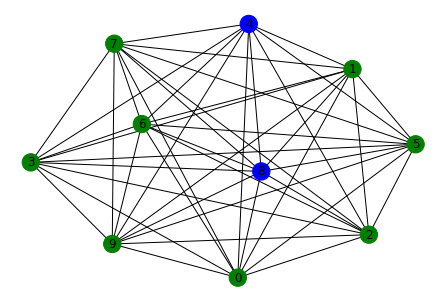

In [35]:

import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

network = nx.complete_graph(n=10)
nsmethod = NSMethod(func=random_walk, params={'agent': None})
nsmodel = NSModel(method=nsmethod, network=network, num_agents=1, start_node=0)
nsmodel.step(num_steps=10)
for agent in nsmodel.agents:
    """Prints out journey of each agent"""
    print(f'Agent: {agent.unique_id}, visited_nodes: {agent.visited_nodes}')

node_color = np.array([])
for n in network:
    """Coloring each visited node green"""
    node_color = np.append(arr=node_color, values='green' if n in agent.visited_nodes else 'blue')

nx.draw_spring(G=network, node_color=node_color, with_labels=True)
plt.show()



Random Walk (Considering Node Weights as Visit Probabilities)

Agent: 0, visited_nodes: [0 9 8 9 6 9 6 9 8 9 8]


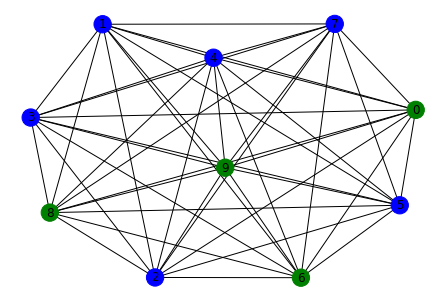

In [36]:

import math
import networkx as nx

network = nx.complete_graph(n=10)
for n in network:
    """Setting node weights exponentially proportional to id"""
    network.nodes[n]['weight'] = math.pow(2, n) * float(n)
    
nsmethod = NSMethod(func=random_walk_weighted, params={'agent': None})
nsmodel = NSModel(method=nsmethod, network=network, num_agents=1, start_node=0)
nsmodel.step(num_steps=10)
for agent in nsmodel.agents:
    """Prints out journey of each agent"""
    print(f'Agent: {agent.unique_id}, visited_nodes: {agent.visited_nodes}')

node_color = np.array([])
for n in network:
    """Coloring each visited node green"""
    node_color = np.append(arr=node_color, values='green' if n in agent.visited_nodes else 'blue')

nx.draw_spring(G=network, node_color=node_color, with_labels=True)
plt.show()


Caterpillar Quota Walk

In [37]:

import math
import networkx as nx

network = nx.complete_graph(n=10)
for n in network:
    """Setting node weights exponentially proportional to id"""
    network.nodes[n]['weight'] = math.pow(2, n) * float(n)
    
nsmethod = NSMethod(func=caterpillar_quota_walk, params={'agent': None, 'Q1': 0.5, 'Q2': 0.9})
nsmodel = NSModel(method=nsmethod, network=network, num_agents=1, start_node=0)
nsmodel.step(num_steps=10)
for agent in nsmodel.agents:
    """Prints out journey of each agent"""
    print(f'Agent: {agent.unique_id}, visited_nodes: {agent.visited_nodes}')

node_color = np.array([])
for n in network:
    """Coloring each visited node green"""
    node_color = np.append(arr=node_color, values='green' if n in agent.visited_nodes else 'blue')

nx.draw_spring(G=network, node_color=node_color, with_labels=True)
plt.show()





AttributeError: 'NXAgent' object has no attribute 'extra_properties'

## NSTest

Complete testing framework for sampling simulation model, evaluated by an agent-based model.

In [15]:

from collections import namedtuple
import param


class NSTest:
    """Framework creates, executes, and evaluates performance on network sampling algorithms"""
    def __init__(self, num_trials: int) -> None:
        """Initializes"""
        self.num_trials = Param.Integer()

